In [66]:
import numpy as np
from splinv import detect
from splinv import hmod
from splinv import darkmapper
from splinv.grid import Cartesian
from configparser import ConfigParser
import splinv
splinv.hmod_v2

""" Test sparse reconstruction of weak lensing dark map
"""
# configuration
configName  =   'test_mock_catalog_atom.ini'
parser      =   ConfigParser()
parser.read(configName)

# halo simulation
z_h     =  0.36
log_m   =  14.75
M_200   =  10.**(log_m)
conc    =  4.
halo    =  splinv.hmod.triaxialJS02(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0., a_over_b = 1, a_over_c = 1)

In [67]:
# Reconstruction Init
parser.set('sparse','mu','3e-4')            #step size for gradient descent
parser.set('lens','resolve_lim','0.02')     #pix
#parser.set('lens','rs_base','%s' %halo.rs)  #Mpc/h
parser.set('sparse','nframe','4' )

# Pixelation
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False)


general_grid    =   splinv.hmod_v2.triaxialJS02_grid_mock(parser)
data2   =   general_grid.add_halo(halo)[1]
gErr    =   np.ones(Grid.shape)*0.05

I strangely encountered a divide by zero error on line 369 in sparse.py. This is because lambda is too large.

In [68]:
dmapper =   darkmapper(parser,data2.real,data2.imag,gErr,lensKer1)

dmapper.lbd=4.      # Lasso penalty
dmapper.lcd=0.      # Ridge penalty in Elastic net
dmapper.nonNeg=True # using non-negative Lasso
dmapper.clean_outcomes()
dmapper.fista_gradient_descent(3000) # run 3000 steps
w   =   dmapper.adaptive_lasso_weight(gamma=2.) # determine the apaptive weight
dmapper.fista_gradient_descent(3000,w=w)        # run adaptive lasso

In [69]:
dmapper.mu=3e-3     # step size for gradient descent
for _ in range(3):  # redo apaptive lasso
    w   =   dmapper.adaptive_lasso_weight(gamma=2.)
    dmapper.fista_gradient_descent(3000,w=w)
dmapper.reconstruct()
c1  =   detect.local_maxima_3D(dmapper.deltaR)


In [71]:
print(c1)
logm_est=   np.log10((dmapper.alphaR*dmapper._w)[6,2,Grid.ny//2,Grid.nx//2])+14.

(array([[ 6, 24, 24]]), array([31.72977772]))


In [72]:
Grid.zlcgrid

array([0.0625, 0.1075, 0.1525, 0.1975, 0.2425, 0.2875, 0.3325, 0.3775,
       0.4225, 0.4675])

not that close but we didn't really expect it to succeed. 

In [73]:
print(logm_est)
print(log_m)

14.754981429171725
14.75


In [74]:
import matplotlib.pyplot as plt

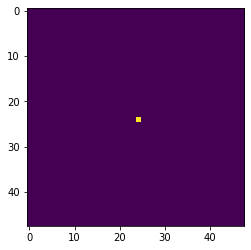

In [76]:
plt.imshow(dmapper.alphaR[6,2]) 

In [24]:
print(dmapper.diff) #this difference is a lot larger than diff in nfw-nfw case. 

[2.45658340e-08 2.44921358e-08 3.12987017e-08 ... 3.78825869e-12
 3.72203000e-12 3.64483853e-12]


(10, 48, 48)


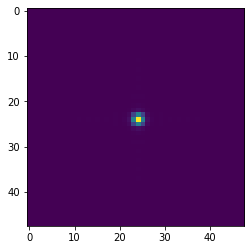

In [29]:
print(dmapper.deltaR.shape)
plt.imshow(dmapper.deltaR[9]) # in the nfw-nfw case, almost all are zero except for one frame that looks like a kappa field
# this looks like it's got multiple nonzero fields.